# Pre-Procesado de Datos
En este script vamos a pre-procesar nuestros datos para luego entrenar el modelo, en el archivo Modelo_prediccion.
### resumen:
* Mejoramos la calidad del archivo $\textit{eci\_cluster\_store} $ solucionando el problema de tener el 10% de valores nulos en la columna $ \textit{cluster} $, lo que representaba tambien un 10% de la demanda total sin clasificar. Procedimiento: Usamos una geo api para obtener las coordenas geograficas apartir de los datos provistos en el archivo $\textit{eci\_stores}$. Para luego graficar todos las coordenas y completar los clusters manualmente.
* Añadimos la columna cluster al archivo de $  \textit{eci\_transactions.csv} $, con el objetivo de utilizarla para mejorar nuestras predicciones de la demanda.
## Pendiente: 
* Vamos a agrupar la infromacion de por subgrupo, para eliminar el sku.
* Vamos a crear lag features y features temporales para mejorar las predicciones 
* Solucionaremos problemas de calidad en el archivo $\textit{eci\_customers.csv}$
* Buscaremos features en sobre confianza de los clientes en el archivo $\textit{eci\_customers.csv}$

* Pasamos a csv los dataframes con todos los cambios realizados
  

In [2]:
from DataLoader import leer_csv
import pandas as pd
from inline_sql import sql, sql_val

In [2]:
ventas=leer_csv("eci_transactions")


In [5]:
ventas

,transaction_id,date,store_id,sku,quantity,price,total_sales,subgroup,store_subgroup_date_id
0,17185,2021-01-01,S00148,CLOMEJA001,1.0,52.80,52.80,Jackets,S00148_Jackets_2021-01-01
1,4108,2021-01-01,S00035,CLOCHIN014,1.0,55.25,55.25,Infants,S00035_Infants_2021-01-01
2,2400,2021-01-01,S00020,BEAHASH005,1.0,40.19,40.19,Shampoo,S00020_Shampoo_2021-01-01
3,7978,2021-01-01,S00068,TOYGABO004,1.0,35.41,35.41,Board Games,S00068_Board Games_2021-01-01
4,6946,2021-01-01,S00059,BEAHASH006,1.0,38.28,38.28,Shampoo,S00059_Shampoo_2021-01-01
...,...,...,...,...,...,...,...,...,...
19004754,19001120,2023-12-31,S00122,GROSNCH011,1.0,10.12,10.12,Chips,S00122_Chips_2023-12-31
19004755,19000886,2023-12-31,S00120,GROSNNU008,1.0,11.40,11.40,Nuts,S00120_Nuts_2023-12-31
19004756,18989298,2023-12-31,STORE0004,CLOMEJA005,1.0,56.86,56.86,Jackets,STORE0004_Jackets_2023-12-31
19004757,18992918,2023-12-31,S00039,CLOCHBO011,1.0,57.24,57.24,Boys,S00039_Boys_2023-12-31


In [30]:
store_clusters=leer_csv("eci_stores_clusters")
store_clusters
tiendas_cluster=sql^"""SELECT cluster, COUNT(DISTINCT store_id) as cantidad FROM store_clusters GROUP BY cluster"""
 #tiene problemas de calidad tambien

In [1]:
store_clusters
tiendas_cluster

NameError: name 'store_clusters' is not defined

In [31]:
tiendas_null=sql^"""SELECT DISTINCT store_id FROM store_clusters WHERE cluster is null"""


In [46]:
17/len(store_clusters) #Pero que tan importantes son esas tiendas?

0.10828025477707007

In [41]:
ventas_tiendas_mal_clasificadas=0
ventas_null={}
tiendas=[]
cant_vendida=[]
for i in range(len(tiendas_null)):
    tienda=tiendas_null.iloc[i,0]
    tiendas.append(tienda)
    cant_vendida.append((sql^(f"""SELECT quantity FROM ventas WHERE store_id='{tienda}' """)).sum().iloc[0])
ventas_null["tienda"]=tiendas
ventas_null["ventas"]=cant_vendida
ventas_null=pd.DataFrame(ventas_null)
ventas_null

,tienda,ventas
0,S00031,182125.0
1,S00139,183592.0
2,S00016,174278.0
3,S00030,174063.0
4,S00046,182644.0
5,S00070,182613.0
6,S00095,174291.0
7,S00096,0.0
8,S00112,180620.0
9,S00127,182942.0


In [52]:
porcentaje_demanda_sin_cluster=ventas_null["ventas"].sum()/ventas["quantity"].sum()
porcentaje_demanda_sin_cluster*100 # no vamos a ignoralo D:

np.float64(9.918961255784385)

In [58]:
stores=leer_csv("eci_stores")
stores


,store_id,brand,store_name,address1,address2,city,state,zip,opendate,closedate,store_type,region
0,S00139,MegaShop,MegaShop - Raleigh,8561 N Maple Blvd,Suite 925,Raleigh,NC,94892,2003-06-10 00:00:00,None,Express,Southeast


In [76]:
from opencage.geocoder import OpenCageGeocode

clave = '86efa54a2ee6456e9b1b1c470156275c'
geocoder = OpenCageGeocode(clave)
lats=[]
lngs=[]
for index, row in stores.iterrows():
    direccion=str(row.iloc[3])+" ,"+str(row.iloc[4])+" ,"+str(row.iloc[5])+" ,"+str(row.iloc[6])+" " +str(row.iloc[7])
    resultados = geocoder.geocode(direccion)
    if resultados:
        lat = resultados[0]['geometry']['lat']
        lng = resultados[0]['geometry']['lng']
        lats.append(lat)
        lngs.append(lng)
    else:
        lats.append(None)
        lngs.append(None)

stores["lat"]=lats
stores["lng"]=lngs

stores

C:\Users\emili\AppData\Local\Temp\ipykernel_25556\3623688684.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  direccion=str(row[3])+" ,"+str(row[4])+" ,"+str(row[5])+" ,"+str(row[6])+" " +str(row[7])


,store_id,brand,store_name,address1,address2,city,state,zip,opendate,closedate,store_type,region,lat,lng
0,S00001,PrimeGoods,PrimeGoods - Hillsboro,5735 NE Washington Pl,NaN,Hillsboro,OR,74820,2015-01-10 00:00:00,NaN,Express,West,44.000130,-120.501390
1,S00002,MegaShop,MegaShop Indianapolis Eastside,3557 Cedar Ct,Unit 89,Indianapolis,IN,33483-1775,2012-03-23 00:00:00,NaN,Express,Midwest,40.000320,-86.250270
2,STORE0003,MarketExpress,MarketExpress - Las Vegas,7870 W Church Ave,NaN,Las Vegas,NV,49099,2021-09-23 00:00:00,NaN,Outlet,West,41.798213,-85.642265
3,STORE0004,MegaShop,MegaShop - Oklahoma City,3105 N Washington Pl,NaN,Oklahoma City,OK,80592,06/30/2015,NaN,Mall,Southwest,35.416754,-97.437832
4,S00005,PrimeGoods,PrimeGoods - Charlotte,8756 SW Maple Ln,Suite 848,Charlotte,NC,32299,2019-06-10 00:00:00,NaN,Express,Southeast,35.500690,-80.000320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,S00153,MegaShop,MegaShop - Oklahoma City,3894 Park Pl,NaN,Oklahoma City,OK,86274,2020-04-01 00:00:00,2033-03-29 00:00:00,Boutique,Southwest,35.944738,-95.278458
153,S00154,BudgetShop,BudgetShop - Newark,5992 View Rd,NaN,Newark,NJ,61756,2009-01-05 00:00:00,NaN,Outlet,Northeast,39.118794,-74.798944
154,S00155,EssentialsPlus,EssentialsPlus - Columbia,6240 N River Ave,NaN,Columbia,SC,99211-2505,2015-05-20 00:00:00,NaN,Mall,Southeast,34.000430,-81.000090
155,S00156,FamilyStore,FamilyStore - Naperville,4679 Market Dr,NaN,Naperville,IL,86674,2014-12-23 00:00:00,NaN,Street,Midwest,39.930196,-88.956912


In [118]:
import seaborn as sns
jijija=sql^"""Select s.store_id, s.lat,s.lng, sc.cluster FROM store_clusters as sc
                   INNER JOIN stores as s on s.store_id=sc.store_id """

clusters=sql^"""SELECT * FROM jijija WHERE cluster is not null"""
nulls=sql^"""SELECT * FROM jijija WHERE cluster is null"""

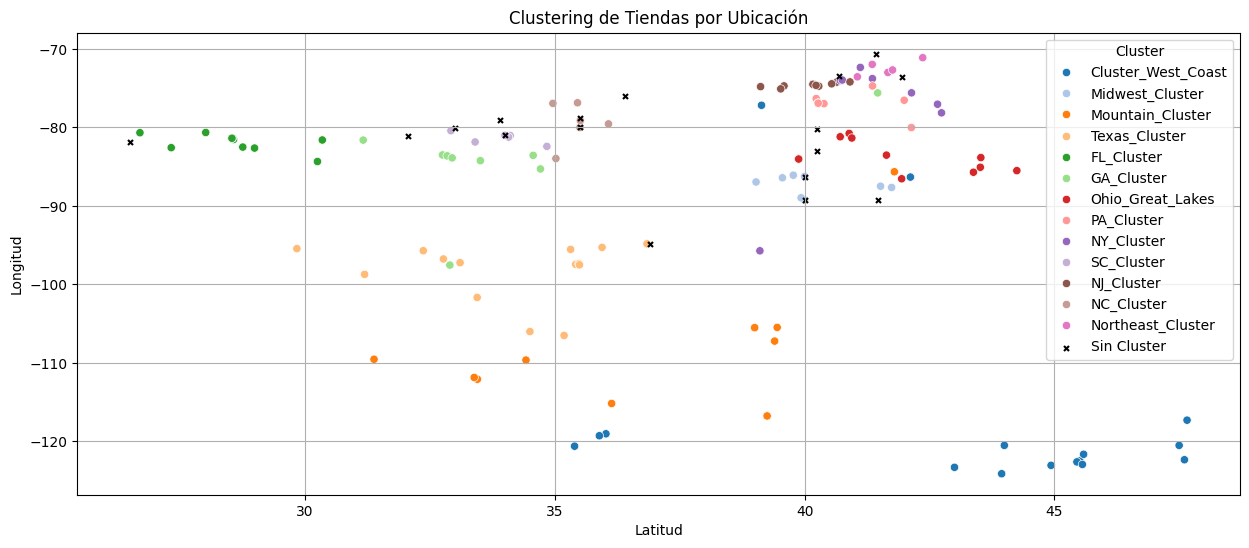

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.scatterplot(x="lat", y="lng", data=clusters, hue="cluster", palette="tab20")
plt.scatter(x="lat", y="lng", data=nulls, c="Black", label= "Sin Cluster",s=13,marker="x")
plt.title("Clustering de Tiendas por Ubicación")
plt.xlabel("Latitud")
plt.ylabel("Longitud")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()

In [122]:
nulls=nulls.sort_values(by="lat")
etiquetas=["FL_Cluster","GA_Cluster","SC_Cluster","SC_Cluster","SC_Cluster","NC_Cluster","NC_Cluster","NC_Cluster","Textas_Cluster",
  "Midwest_Cluster","Midwest_Cluster","Ohio_Great_Lakes","Ohio_Great_Lakes","NJ_Cluster","Northeast_Cluster","Midwest_Cluster","Northeast_Cluster" ]
nulls["cluster"]=etiquetas
nulls

,store_id,lat,lng,cluster
13,S00127,26.497128,-81.892009,FL_Cluster
7,S00070,32.055205,-81.138080,GA_Cluster
16,S00140,32.997603,-80.099652,SC_Cluster
5,S00046,33.893502,-79.018024,SC_Cluster
10,S00098,34.000430,-81.000090,SC_Cluster
14,S00134,35.500690,-80.000320,NC_Cluster
11,S00112,35.507179,-78.743272,NC_Cluster
15,S00139,36.400632,-76.019795,NC_Cluster
4,S00031,36.901478,-94.862727,Textas_Cluster
0,S00016,40.000320,-89.250370,Midwest_Cluster


In [ ]:
for _, row in nulls.iterrows():
    store_clusters.loc[(store_clusters["store_id"]==row[0]),["cluster"]]=row[3]
    

In [146]:
store_clusters.isnull().sum() #mision cumplida
store_clusters

,store_id,brand,store_name,cluster
0,S00001,PrimeGoods,PrimeGoods - Hillsboro,Cluster_West_Coast
1,S00002,MegaShop,MegaShop Indianapolis Eastside,Midwest_Cluster
2,STORE0003,MarketExpress,MarketExpress - Las Vegas,Mountain_Cluster
3,STORE0004,MegaShop,MegaShop - Oklahoma City,Texas_Cluster
4,S00005,PrimeGoods,PrimeGoods - Charlotte,NC_Cluster
...,...,...,...,...
152,S00153,MegaShop,MegaShop - Oklahoma City,Texas_Cluster
153,S00154,BudgetShop,BudgetShop - Newark,NJ_Cluster
154,S00155,EssentialsPlus,EssentialsPlus - Columbia,SC_Cluster
155,S00156,FamilyStore,FamilyStore - Naperville,Midwest_Cluster


In [147]:
store_to_cluster={}
for _, row in store_clusters.iterrows():
    store_to_cluster[row[0]]=row[3]
ventas["cluster"] = ventas["store_id"].map(store_to_cluster)

C:\Users\emili\AppData\Local\Temp\ipykernel_25556\1470202185.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  store_to_cluster[row[0]]=row[3]


In [150]:
ventas.to_csv("ventas_con_cluster.csv",index=False)

## Modificaremos el agrupado de los datos de transacciones

In [152]:
ventas.columns

Index(['transaction_id', 'date', 'store_id', 'sku', 'quantity', 'price',
       'total_sales', 'subgroup', 'store_subgroup_date_id', 'cluster'],
      dtype='object')

In [155]:
ventas.loc[(ventas["sku"]=="CLOMEJA001") & (ventas["store_id"]=="S00148") ]

,transaction_id,date,store_id,sku,quantity,price,total_sales,subgroup,store_subgroup_date_id,cluster
0,17185,2021-01-01,S00148,CLOMEJA001,1.0,52.80,52.80,Jackets,S00148_Jackets_2021-01-01,Ohio_Great_Lakes
5722,17183,2021-01-01,S00148,CLOMEJA001,2.0,52.80,105.61,Jackets,S00148_Jackets_2021-01-01,Ohio_Great_Lakes
6820,17182,2021-01-01,S00148,CLOMEJA001,1.0,52.80,52.80,Jackets,S00148_Jackets_2021-01-01,Ohio_Great_Lakes
7164,17184,2021-01-01,S00148,CLOMEJA001,1.0,52.80,52.80,Jackets,S00148_Jackets_2021-01-01,Ohio_Great_Lakes
11776,17181,2021-01-01,S00148,CLOMEJA001,1.0,52.80,52.80,Jackets,S00148_Jackets_2021-01-01,Ohio_Great_Lakes
...,...,...,...,...,...,...,...,...,...,...
18301772,18315082,2023-11-22,S00148,CLOMEJA001,1.0,55.65,55.65,Jackets,S00148_Jackets_2023-11-22,Ohio_Great_Lakes
18755974,18762584,2023-12-16,S00148,CLOMEJA001,1.0,55.87,55.87,Jackets,S00148_Jackets_2023-12-16,Ohio_Great_Lakes
18759806,18762583,2023-12-16,S00148,CLOMEJA001,2.0,55.87,111.73,Jackets,S00148_Jackets_2023-12-16,Ohio_Great_Lakes
18924987,18939937,2023-12-27,S00148,CLOMEJA001,1.0,57.33,57.33,Jackets,S00148_Jackets_2023-12-27,Ohio_Great_Lakes


## Investiguemos un poco sobre el sku

In [ ]:
ventas=leer_csv("eci_transactions")

In [3]:
ventas

,transaction_id,date,store_id,sku,quantity,price,total_sales,subgroup,store_subgroup_date_id
0,17185,2021-01-01,S00148,CLOMEJA001,1.0,52.80,52.80,Jackets,S00148_Jackets_2021-01-01
1,4108,2021-01-01,S00035,CLOCHIN014,1.0,55.25,55.25,Infants,S00035_Infants_2021-01-01
2,2400,2021-01-01,S00020,BEAHASH005,1.0,40.19,40.19,Shampoo,S00020_Shampoo_2021-01-01
3,7978,2021-01-01,S00068,TOYGABO004,1.0,35.41,35.41,Board Games,S00068_Board Games_2021-01-01
4,6946,2021-01-01,S00059,BEAHASH006,1.0,38.28,38.28,Shampoo,S00059_Shampoo_2021-01-01
...,...,...,...,...,...,...,...,...,...
19004754,19001120,2023-12-31,S00122,GROSNCH011,1.0,10.12,10.12,Chips,S00122_Chips_2023-12-31
19004755,19000886,2023-12-31,S00120,GROSNNU008,1.0,11.40,11.40,Nuts,S00120_Nuts_2023-12-31
19004756,18989298,2023-12-31,STORE0004,CLOMEJA005,1.0,56.86,56.86,Jackets,STORE0004_Jackets_2023-12-31
19004757,18992918,2023-12-31,S00039,CLOCHBO011,1.0,57.24,57.24,Boys,S00039_Boys_2023-12-31


In [6]:
ventas.loc[(ventas["store_id"]=='S00148') & (ventas["subgroup"]=="Jackets")]

,transaction_id,date,store_id,sku,quantity,price,total_sales,subgroup,store_subgroup_date_id
0,17185,2021-01-01,S00148,CLOMEJA001,1.0,52.80,52.80,Jackets,S00148_Jackets_2021-01-01
5722,17183,2021-01-01,S00148,CLOMEJA001,2.0,52.80,105.61,Jackets,S00148_Jackets_2021-01-01
6820,17182,2021-01-01,S00148,CLOMEJA001,1.0,52.80,52.80,Jackets,S00148_Jackets_2021-01-01
7164,17184,2021-01-01,S00148,CLOMEJA001,1.0,52.80,52.80,Jackets,S00148_Jackets_2021-01-01
11776,17181,2021-01-01,S00148,CLOMEJA001,1.0,52.80,52.80,Jackets,S00148_Jackets_2021-01-01
...,...,...,...,...,...,...,...,...,...
18937221,18939944,2023-12-27,S00148,CLOMEJA010,1.0,56.41,56.41,Jackets,S00148_Jackets_2023-12-27
18940506,18939946,2023-12-27,S00148,CLOMEJA010,2.0,56.41,112.81,Jackets,S00148_Jackets_2023-12-27
18940933,18939939,2023-12-27,S00148,CLOMEJA005,1.0,58.68,58.68,Jackets,S00148_Jackets_2023-12-27
18992195,19003798,2023-12-31,S00148,CLOMEJA004,2.0,47.69,95.37,Jackets,S00148_Jackets_2023-12-31


In [14]:
ventas_agg=sql^"""SELECT date,store_id,sku,sum(quantity) as demand, mean(price) as mean_price FROM ventas group by date,store_id,sku"""

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [17]:
ventas_agg

,date,store_id,sku,demand,mean_price
0,2021-01-23,S00088,ELEMOAC005,1.0,230.24
1,2021-01-23,S00088,HOMCOPO002,4.0,65.09
2,2021-01-23,S00039,TOYEDAR002,6.0,28.48
3,2021-01-23,STORE0133,BEAHASH008,5.0,48.03
4,2021-01-23,S00121,CLOWOOU010,4.0,51.61
...,...,...,...,...,...
6859688,2023-12-28,S00016,HOMCOUT007,4.0,85.10
6859689,2023-12-28,S00148,ELECOTA008,3.0,350.27
6859690,2023-12-28,S00091,ELECOTA005,1.0,240.78
6859691,2023-12-28,S00106,ELEMOAC006,1.0,339.30


In [21]:
#Ahora vamos a ver que tanto varia el precio del mismo tipo de producto por tienda
stores=leer_csv("Stores_coordenadas")
stores=stores[["store_id"]]

In [39]:
precio_promedio_jackets_por_tienda={}
#ventas_sin_sku=ventas_agg.drop("sku",axis=1)
ventas_tienda_dia=ventas_sin_sku.groupby(["date","store_id"],as_index=False).agg({"demand":"sum","mean_price":"mean"})
ventas_tienda_dia
ventas = ventas.merge(ventas_tienda_dia[["date","store_id","mean_price"]], on=["date", "store_id"], how="left")


In [80]:
# pendiente a pensar= que pasa si meapeamos STORE X PRODUCTO -> int?
store_x_subgroup=sql^"""SELECT DISTINCT store_id, subgroup FROM ventas"""
store_x_subgroup
codigo=range(0,73*152) #productos*tiendas
store_x_subgroup["codigo"]=codigo

ventas_con_codigo= ventas.merge(store_x_subgroup,on=["store_id","subgroup"], how="left")

In [ ]:
store_x_subgroup.to_csv("storexsubgoup.csv",index=False) #codificacion entre store_id y subgroup

In [81]:
ventas_con_codigo.drop(["transaction_id","price","store_id","sku","subgroup","store_subgroup_date_id"],axis=1,inplace=True)

In [75]:
ventas_con_codigo

,date,quantity,price,total_sales,mean_price,codigo
0,2021-01-01,1.00,52.80,52.80,71.24,2734
1,2021-01-01,1.00,55.25,55.25,62.27,9699
2,2021-01-01,1.00,40.19,40.19,60.43,5509
3,2021-01-01,1.00,35.41,35.41,60.39,8340
4,2021-01-01,1.00,38.28,38.28,57.04,2735
...,...,...,...,...,...,...
19004754,2023-12-31,1.00,10.12,10.12,66.10,4391
19004755,2023-12-31,1.00,11.40,11.40,60.64,5769
19004756,2023-12-31,1.00,56.86,56.86,62.40,9412
19004757,2023-12-31,1.00,57.24,57.24,57.95,4839


In [82]:

ventas_con_codigo=sql^"""SELECT Distinct date, codigo, sum(quantity) as demand, mean(mean_price) as mean_price, FROM ventas_con_codigo GROUP BY date, codigo"""
ventas_con_codigo

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,date,codigo,demand,mean_price
0,2021-02-04,1675,6.00,48.98
1,2021-02-04,8537,10.00,72.97
2,2021-02-04,2032,3.00,64.20
3,2021-02-04,3995,11.00,96.37
4,2021-02-04,8258,5.00,89.13
...,...,...,...,...
5206788,2023-12-27,4807,1.00,57.86
5206789,2023-12-27,1575,1.00,77.06
5206790,2023-12-27,274,1.00,65.06
5206791,2023-12-27,6884,2.00,66.17


In [1]:
from DataLoader import importar_ventas
from DataLoader import leer_csv
import pandas as pd
from inline_sql import sql, sql_val

In [2]:
ventas=importar_ventas()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [3]:
ventas

,demand,mean_price,cluster,cod_store_subgroup,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_lag_7,day,month,year
4529699,5.0,33.4500,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,1,2021
4348480,6.0,43.2200,5,0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,9,1,2021
4585796,8.0,34.7900,5,0,6.0,5.0,NaN,NaN,NaN,NaN,NaN,10,1,2021
2503,2.0,39.2300,5,0,8.0,6.0,5.0,NaN,NaN,NaN,NaN,12,1,2021
1610,2.0,34.0300,5,0,2.0,8.0,6.0,5.0,NaN,NaN,NaN,14,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613173,9.0,26.4775,3,11095,6.0,3.0,11.0,12.0,3.0,4.0,1.0,21,12,2023
5171032,2.0,34.3800,3,11095,9.0,6.0,3.0,11.0,12.0,3.0,4.0,24,12,2023
5190919,4.0,32.9300,3,11095,2.0,9.0,6.0,3.0,11.0,12.0,3.0,27,12,2023
3950642,2.0,25.3800,3,11095,4.0,2.0,9.0,6.0,3.0,11.0,12.0,28,12,2023


In [4]:
ventas.columns

Index(['demand', 'mean_price', 'cluster', 'cod_store_subgroup', 'demand_lag_1',
       'demand_lag_2', 'demand_lag_3', 'demand_lag_4', 'demand_lag_5',
       'demand_lag_6', 'demand_lag_7', 'day', 'month', 'year'],
      dtype='object')

In [8]:
FEATURES=['day','month','year', 'demand', 'mean_price', 'cluster', 'cod_store_subgroup',
       'demand_lag_1', 'demand_lag_2', 'demand_lag_3', 'demand_lag_4',
       'demand_lag_5', 'demand_lag_6', 'demand_lag_7']
TARGET=['demand']

test=ventas.groupby("cod_store_subgroup").tail(7)
train=ventas.drop(test.index)

X_train=train[FEATURES]
y_train=train[TARGET]
X_test=test[FEATURES]
y_test=test[TARGET]

,demand,mean_price,cluster,cod_store_subgroup,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_lag_7,day,month,year
4529699,5.0,33.450000,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,1,2021
4348480,6.0,43.220000,5,0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,9,1,2021
4585796,8.0,34.790000,5,0,6.0,5.0,NaN,NaN,NaN,NaN,NaN,10,1,2021
2503,2.0,39.230000,5,0,8.0,6.0,5.0,NaN,NaN,NaN,NaN,12,1,2021
1610,2.0,34.030000,5,0,2.0,8.0,6.0,5.0,NaN,NaN,NaN,14,1,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2575364,1.0,26.140000,3,11095,7.0,12.0,7.0,7.0,8.0,6.0,3.0,29,11,2023
2528106,4.0,33.850000,3,11095,1.0,7.0,12.0,7.0,7.0,8.0,6.0,2,12,2023
1857510,3.0,26.460000,3,11095,4.0,1.0,7.0,12.0,7.0,7.0,8.0,5,12,2023
2073772,12.0,31.470000,3,11095,3.0,4.0,1.0,7.0,12.0,7.0,7.0,6,12,2023


In [9]:
X_test

,demand,mean_price,cluster,cod_store_subgroup,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_lag_7,day,month,year
4302461,6.0,39.795000,5,0,2.0,6.0,4.0,2.0,2.0,5.0,33.0,19,12,2023
4612405,2.0,38.590000,5,0,6.0,2.0,6.0,4.0,2.0,2.0,5.0,20,12,2023
5104520,8.0,40.006667,5,0,2.0,6.0,2.0,6.0,4.0,2.0,2.0,22,12,2023
4948714,5.0,36.660000,5,0,8.0,2.0,6.0,2.0,6.0,4.0,2.0,23,12,2023
5093264,9.0,37.927500,5,0,5.0,8.0,2.0,6.0,2.0,6.0,4.0,25,12,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613173,9.0,26.477500,3,11095,6.0,3.0,11.0,12.0,3.0,4.0,1.0,21,12,2023
5171032,2.0,34.380000,3,11095,9.0,6.0,3.0,11.0,12.0,3.0,4.0,24,12,2023
5190919,4.0,32.930000,3,11095,2.0,9.0,6.0,3.0,11.0,12.0,3.0,27,12,2023
3950642,2.0,25.380000,3,11095,4.0,2.0,9.0,6.0,3.0,11.0,12.0,28,12,2023


In [14]:
ventas.loc[ventas["demand"].isnull()]

,demand,mean_price,cluster,cod_store_subgroup,demand_lag_1,demand_lag_2,demand_lag_3,demand_lag_4,demand_lag_5,demand_lag_6,demand_lag_7,day,month,year
1778168,NaN,9.08,2,2,10.0,2.0,3.0,3.0,4.0,3.0,4.0,30,1,2022
4334967,NaN,72.04,7,8,7.0,7.0,3.0,7.0,4.0,7.0,5.0,1,11,2023
999826,NaN,23.82,10,12,3.0,4.0,6.0,10.0,10.0,6.0,4.0,17,10,2022
3260219,NaN,36.68,0,14,4.0,4.0,1.0,3.0,1.0,1.0,1.0,10,4,2023
1588814,NaN,81.57,11,15,16.0,1.0,5.0,8.0,2.0,14.0,10.0,19,12,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679936,NaN,116.29,7,11070,2.0,6.0,6.0,7.0,6.0,2.0,6.0,11,2,2021
4151023,NaN,69.64,7,11070,7.0,11.0,9.0,17.0,2.0,4.0,2.0,29,9,2021
2186647,NaN,71.57,10,11077,5.0,1.0,3.0,8.0,3.0,2.0,1.0,19,7,2021
2364343,NaN,85.97,10,11085,7.0,2.0,10.0,3.0,3.0,1.0,6.0,7,4,2022


# Vuelta a empezar, encontramos null en demanda.

In [16]:
ventas=leer_csv("eci_transactions")


In [19]:
ventas.isnull().sum()

transaction_id                0
date                          0
store_id                      0
sku                           0
quantity                  95087
price                         0
total_sales                   0
subgroup                      0
store_subgroup_date_id        0
dtype: int64

In [24]:
ventas.loc[ventas["quantity"]!=ventas["total_sales"]/ventas["price"]]

,transaction_id,date,store_id,sku,quantity,price,total_sales,subgroup,store_subgroup_date_id
9,6673,2021-01-01,S00057,SPOFISU006,2.0,90.23,180.47,Supplements,S00057_Supplements_2021-01-01
11,17744,2021-01-01,S00152,HOMFUBE011,3.0,91.31,273.94,Bedroom,S00152_Bedroom_2021-01-01
20,10004,2021-01-01,S00085,TOYACVE003,3.0,33.98,101.95,Vehicles,S00085_Vehicles_2021-01-01
21,5737,2021-01-01,S00048,GROBEJU007,2.0,11.33,22.65,Juice,S00048_Juice_2021-01-01
26,9544,2021-01-01,S00081,TOYACVE002,2.0,30.27,60.55,Vehicles,S00081_Vehicles_2021-01-01
...,...,...,...,...,...,...,...,...,...
19004735,19002202,2023-12-31,STORE0133,CLOMESH006,2.0,49.41,98.83,Shirts,STORE0133_Shirts_2023-12-31
19004737,18989910,2023-12-31,S00010,ELEAUHO001,3.0,364.62,1093.85,Home Audio,S00010_Home Audio_2023-12-31
19004748,19002505,2023-12-31,S00136,ELEMOAC001,2.0,313.41,626.83,Accessories,S00136_Accessories_2023-12-31
19004749,18994177,2023-12-31,000052,SPOOUWA004,3.0,97.33,292.00,Water Sports,000052_Water Sports_2023-12-31


In [26]:
ventas["diferencia"]=ventas["quantity"]*ventas["price"]-ventas["total_sales"]
ventas["diferencia"].describe() #errores de redondeo

count    1.890967e+07
mean    -3.721376e-06
std      4.688137e-03
min     -2.800000e-01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.900000e-01
Name: diferencia, dtype: float64

In [27]:
ventas["quantity"]=ventas["total_sales"]//ventas["price"]
ventas["diferencia"]=ventas["quantity"]*ventas["price"]-ventas["total_sales"]
ventas["diferencia"].describe() #solucionado

count    1.900476e+07
mean    -5.404804e+00
std      2.955803e+01
min     -4.285800e+02
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      0.000000e+00
Name: diferencia, dtype: float64

In [28]:
ventas.isnull().sum() #objetivo cumplido

transaction_id            0
date                      0
store_id                  0
sku                       0
quantity                  0
price                     0
total_sales               0
subgroup                  0
store_subgroup_date_id    0
diferencia                0
dtype: int64

# Conseguimos un R**2 de 0.0336 
## pesimo pero la historia continua